Note book to compare the fragmentations we get with the optimal results

In [57]:
import os
import sys
import pylab as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
home_folder = '/Users/simon'
home_folder = '/home/simon'

In [59]:
sys.path.append(os.path.join(home_folder,'git','pymzm'))
sys.path.append(os.path.join(home_folder,'git','vimms'))

In [60]:
from mass_spec_utils.data_import.mzml import MZMLFile
from mass_spec_utils.data_import.mzmine import load_picked_boxes,map_boxes_to_scans
from vimms.Roi import make_roi

In [17]:
standard = 'QCB'
data_folder = os.path.join(home_folder,'git','vimms','experimental','simon_res','loop_controller')
pp_folder = os.path.join(home_folder,'git','vimms','experimental','simon_res','QCB')

In [40]:
optimal_mzml_file = os.path.join(data_folder,'optimal_0.mzml')
pp_file = os.path.join(pp_folder,'qcb_pp_wide.csv')
comparison_mzml_file = os.path.join(data_folder,'optimal_2.mzml')

In [41]:
boxes = load_picked_boxes(pp_file)
print("Loaded {} boxes".format(len(boxes)))

['row ID', 'row m/z', 'row retention time', 'from_controller_TopN_QCB.mzML filtered Peak m/z', 'from_controller_TopN_QCB.mzML filtered Peak RT start', 'from_controller_TopN_QCB.mzML filtered Peak RT end', 'from_controller_TopN_QCB.mzML filtered Peak height', 'from_controller_TopN_QCB.mzML filtered Peak area', 'from_controller_TopN_QCB.mzML filtered Peak m/z min', 'from_controller_TopN_QCB.mzML filtered Peak m/z max', '']
Loaded 5325 boxes


(array([1373., 1203.,  610.,  555.,  354.,  301.,  219.,  368.,  327.,
          15.]),
 array([  1.15385306,  16.82913535,  32.50441763,  48.17969992,
         63.85498221,  79.5302645 ,  95.20554679, 110.88082907,
        126.55611136, 142.23139365, 157.90667594]),
 <a list of 10 Patch objects>)

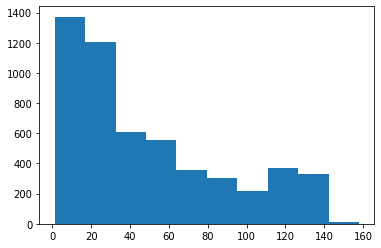

In [42]:
box_widths = [x.rt_range_in_seconds[1] - x.rt_range_in_seconds[0] for x in boxes]
plt.hist(box_widths)

In [43]:
# define some plotting ranges

In [44]:
optimal_file = MZMLFile(optimal_mzml_file)
comparison_file = MZMLFile(comparison_mzml_file)

Loaded 3744 scans
Loaded 2671 scans


In [45]:
optimal_s2b,optimal_b2s = map_boxes_to_scans(optimal_file,boxes,half_isolation_window=0)
comparison_s2b,comparison_b2s = map_boxes_to_scans(comparison_file,boxes,half_isolation_window=0)

In [46]:
print("Optimal: {}".format(len(optimal_b2s)))
print("Comparison: {}".format(len(comparison_b2s)))
optimal_boxes = set(optimal_b2s.keys())
comparison_boxes = set(comparison_b2s.keys())
missing = optimal_boxes - comparison_boxes

Optimal: 1658
Comparison: 442


In [47]:
over_scan = 0
# how often do we fragment a peak >1 time
for box,scans in comparison_b2s.items():
    if len(scans) > 1:
        over_scan+=1
print(over_scan)

12


(6, 18)

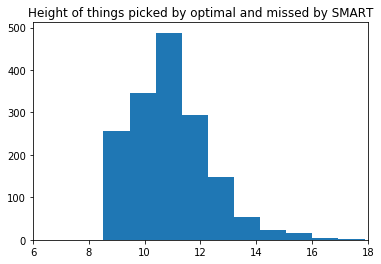

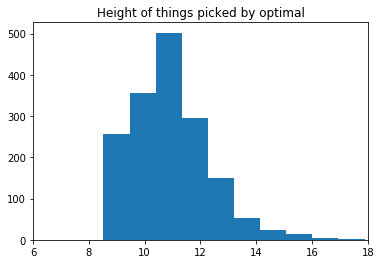

In [48]:
# what intensity are the missing ones
plt.hist([np.log(x.height) for x in missing])
plt.title('Height of things picked by optimal and missed by SMART')
plt.xlim([6,18])
plt.figure()
plt.hist([np.log(x.height) for x in optimal_boxes])
plt.title('Height of things picked by optimal')
# tend to be lower intensity
plt.xlim([6,18])

In [49]:
missing = list(missing)
print(missing[1].mz_range,missing[1].rt_range_in_seconds)

[374.1716003417969, 374.1719055175781] [398.98740559999976, 414.1630125109998]


In [50]:
comparison_ms2_scans = set(filter(lambda x: x.ms_level == 2,comparison_file.scans))
print(len(comparison_file.scans))
print(len(comparison_ms2_scans))
bad_scans = comparison_ms2_scans - set(comparison_s2b.keys())
bad_scans = list(bad_scans)
for i in range(10):
    bad_scan = bad_scans[i]
    print(bad_scan.precursor_mz,60.0*bad_scan.rt_in_minutes)

2671
678
293.1912154140929 207.24999999999957
264.0874971619753 277.9099999999966
298.14423455440203 254.11999999999776
235.08718184794327 263.55999999999733
446.1649198762729 511.53999999998877
385.1638886861863 203.73999999999972
355.2484576830867 203.53999999999974
437.1466099214411 270.179999999997
134.0450750160137 523.3099999999904
455.2438486017088 232.43999999999858


In [51]:
min_mz = 200
max_mz = 300
min_rt = 200
max_rt = 300
min_ms1_intensity = 500 # for plotting

In [52]:
optimal_frag_scans = sub_scans = list(filter(lambda x: x.ms_level == 2 and 60*x.rt_in_minutes >= min_rt and 60*x.rt_in_minutes <= max_rt and x.precursor_mz >= min_mz and x.precursor_mz <= max_mz,optimal_file.scans))
comparison_frag_scans = sub_scans = list(filter(lambda x: x.ms_level == 2 and 60*x.rt_in_minutes >= min_rt and 60*x.rt_in_minutes <= max_rt and x.precursor_mz >= min_mz and x.precursor_mz <= max_mz,comparison_file.scans))

36
347


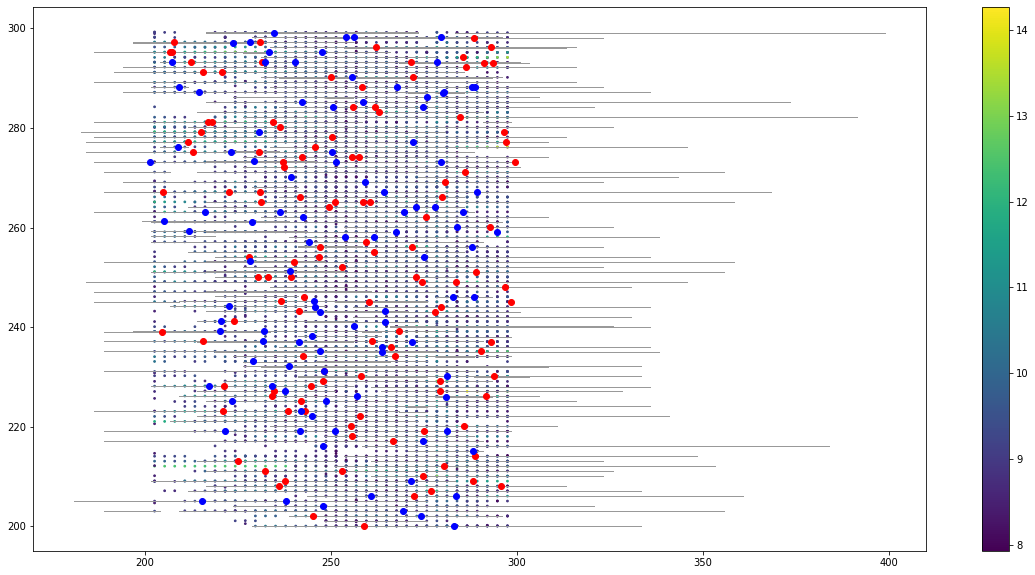

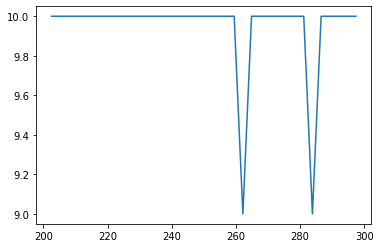

In [53]:
plt.figure(figsize=(20,10))
sub_scans = list(filter(lambda x: x.ms_level == 1 and 60*x.rt_in_minutes >= min_rt and 60*x.rt_in_minutes <= max_rt,optimal_file.scans))
print(len(sub_scans))
mz = []
rt = []
intensity = []
ms2_counts = []
rts = []
for scan in sub_scans:
    ms2_counts.append(count_ms2(scan,optimal_file.scans))
    rts.append(scan.rt_in_minutes*60)
    sub_peaks = list(filter(lambda x: x[0] >= min_mz and x[0] <= max_mz and x[1] >= min_ms1_intensity,scan.peaks))
    for peak in sub_peaks:
        mz.append(peak[0])
        rt.append(scan.rt_in_minutes*60)
        intensity.append(peak[1])
plt.scatter(rt,mz,c = np.log(intensity),s=3)
plt.colorbar()

from matplotlib.patches import Rectangle

# add the boxes
sub_boxes = list(filter(lambda x: x.mz >= min_mz and x.mz <= max_mz and 60.0*x.rt_in_minutes >= min_rt and 60.0*x.rt_in_minutes <= max_rt,boxes))
print(len(sub_boxes))
for box in sub_boxes:
    bottom_left = [box.mz_range[0],60.0*box.rt_range[0]]
    width = 60.0*(box.rt_range[1] - box.rt_range[0])
    height = box.mz_range[1] - box.mz_range[0]
    plt.plot([60.0*i for i in box.rt_range],[box.mz_range[0],box.mz_range[0]],color = [0.6,0.6,0.6],linewidth=1)
    plt.plot([60.0*i for i in box.rt_range],[box.mz_range[1],box.mz_range[1]],color = [0.6,0.6,0.6],linewidth=1)
    plt.plot([60.0*box.rt_range[0],60.0*box.rt_range[0]],box.mz_range,color = [0.6,0.6,0.6],linewidth=1)
    plt.plot([60.0*box.rt_range[1],60.0*box.rt_range[1]],box.mz_range,color = [0.6,0.6,0.6],linewidth=1)


for o in optimal_frag_scans:
    plt.plot(60.0*o.rt_in_minutes,o.precursor_mz,'ro')
    
for o in comparison_frag_scans:
    plt.plot(60.0*o.rt_in_minutes,o.precursor_mz,'bo')

    
plt.figure()
plt.plot(rts,ms2_counts)

In [32]:
# count the # ms2 scans for each MS1 scan
def count_ms2(ms1_scan,scans):
    sub_scans = list(filter(lambda x: x.ms_level == 2 and x.previous_ms1 == ms1_scan,scans))
    return len(sub_scans)

In [66]:
print(ms2_counts)

[7, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 8]


In [54]:
small_ones = filter(lambda x: x.height < 5000,boxes)

In [56]:
print(len(list(small_ones)))

1560
